# Broadband Growth Across the US
## Machine Learning
### Chester Hitz | Springboard Data Science Career Track | Capstone I

The goal of this final component of my capstone is to apply what I have discovered thus far in my project and apply it to build a predictive model using tools from sci-kit learn. I will build and evaluate several models, then try to establish a deeper understanding of my model's strengths and weaknesses as well as the real-world applications of my results.

### Work thus far
I started this project with my data wrangling component, where I assembled a DataFrame consisting of 13k rows, each one representing a county in a particular year across a four year period (2011-2015) with a target variable. The target variable is a number corresponding to a category for "residential fixed Internet access connections per 1,000 households by county for both service over 200 kbps in at least one direction and service at least 10 Mbps down / 1 Mbps up.". This is the BSC, or broadband subscription category. The categories are listed as follows, with x representing connections per 1,000 households:
* 0: Zero 
* 1: Zero < x <= 200 
* 2: 200 < x <= 400 
* 3: 400 < x <= 600 
* 4: 600 < x <= 800 
* 5: 800 < x

I then populated this DataFrame further with various features pulled from the census API and other sources to complete my DataWrangling component. In my Data Storytelling and Inferential Statistics modules, I examined the data and found 1) that BSC did move upward over the study period and 2) that economic factors were the most closely correlated to BSC.

In this final module, I will build on those previous units to construct a predictive model. Though I am technically predicting for a category, the category is essentially bins for numerical data, so regression models will be used in this case.

### Preprocessing

In [1]:
# begin by importing all relevant libraries & previous data
# standard data analysis libraries...
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

# ... and various scikit-learn functions
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import Imputer, normalize
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor



# import relevant data
broadband = pd.read_csv('broadband.csv', dtype={'county_fips':str})

My first step here is preprocessing my data for sci-kit learn's algorithms: Dropping unnecessary categorical features and the target variable and imputing missing values

In [2]:
# create an imputer object (applied throughout project)
imp = Imputer(missing_values='NaN', strategy='median', axis=1)

# remove unnecessary features
lr_bb = broadband.drop(['Unnamed: 0', 'state', 'statename'], axis=1)

Second step is designing a function that will allow me to quickly preprocess my data and run it through a selected model to produce metrics for comparison with other models.

In [3]:
# build a function to train and test different DataFrames

# coefficient printer function from: http://blog.datadive.net/selecting-good-features-part-ii-linear-models-and-regularization/
def pretty_print_linear(coefs, names = None, sort = False):
    if names == None:
        names = ["X%s" % x for x in range(len(coefs))]
    lst = zip(coefs, names)
    if sort:
        lst = sorted(lst,  key = lambda x:-np.abs(x[0]))
    return "\n + ".join("%s * %s" % (round(coef, 3), name)
                                   for coef, name in lst)

# generalized preprocessing function drops target variable, imputes missing values, reconstitutes the dataframe
# and partitions it for training purposes
def preprocess(df, return_features_df=False):
    df_features_wNaN = df.drop('BSC',axis = 1)
    if return_features_df: global df_features
    df_features = pd.DataFrame(imp.fit_transform(df_features_wNaN))
    df_features.columns = df_features_wNaN.columns
    return train_test_split(df_features, df.BSC, test_size = .2, random_state=24)

# and a pipeline for regression models
def Pipeline(df, model, coef_print=True, return_df=False):
    
    # preprocess & segment data
    X_train, X_holdout, y_train, y_holdout = preprocess(df, return_features_df=return_df)
    
    # fit data to a linear regression model
    scores = cross_val_score(model,X_train,y_train, cv=5)
    
    # evaluate RMSE on holdout set
    reg = model.fit(X_train,y_train)
    BSC_predicted = reg.predict(X_holdout)
    BSC_predicted[BSC_predicted > 5] = 5
    global holdout_rmse
    holdout_rmse = np.sqrt(mean_squared_error(BSC_predicted, y_holdout))
    
    print('Training test CV scores:{}'.format(scores))
    print('Hold-out RMSE: {}'.format(holdout_rmse))
    if coef_print==True:
        print("Linear model:\n", pretty_print_linear(reg.coef_, names=list(df.columns), sort=True))
    print('--------------------')
    
    if return_df==True: 
        df_copy = df
        df_copy.loc[:,'Predicted'] = reg.predict(df_features)
        df_copy.loc[:,'Residual'] = df['BSC'] - df['Predicted']
        return df_copy

Third step, performed below, is model selection.

## Model Selection

### Linear Regression

Simple linear regression models the relationship between the magnitude of one variable and that of a second. Regression goes beyond the previous analysis of regression that measured the strength of the association between variables, and tries to quantify and utilize that relationship to predict.

In the code below, my Pipeline function is utilized on the dataset, and the RMSE score is provided along with a listing of the coefficients.

In [4]:
Pipeline(lr_bb, LinearRegression())

Training test CV scores:[ 0.52391036  0.50037514  0.48623379  0.51861564  0.51059166]
Hold-out RMSE: 0.5693962291818182
Linear model:
 0.124 * Year
 + 0.036 * NoEnglish
 + 0.036 * EmploymentRate
 + -0.027 * AgJobs
 + 0.023 * Families
 + -0.022 * ArmedForcesPer
 + 0.022 * BornInState
 + -0.019 * BSC
 + -0.018 * AptBuildings
 + 0.016 * InformationJobsPer
 + 0.011 * MobileHomes
 + -0.008 * HighSchoolGrads
 + -0.004 * PublicTrans
 + -0.004 * colleges
 + 0.003 * InformationJobs
 + 0.0 * TractArea
 + -0.0 * Annual Payroll
 + 0.0 * Unemployed
 + 0.0 * Population
 + 0.0 * HomePrice
 + -0.0 * NumberofFirms
 + -0.0 * PctBachelors
 + 0.0 * TotalHouseholds
 + -0.0 * Rural_Pct
 + 0.0 * Income
 + -0.0 * county_fips
 + -0.0 * SameHouseResidence
--------------------


Fitting my data to the most generalized linear regression model produces an RMSE of .57, meaning that is the average error from actual BSC is about half. This is not awful, but improvements can be made in two ways: 1) a simpler model, and 2) a lower RMSE score indicating more accurate predictions.

### Ridge Regression

In regression, it is always best to take the simplest approach possible and use the least number of predictor variables when possible.  Ridge regression is a linear model that simplifies Linear Regression by making the magnitude of the coefficients as small as absolutely possible while still predicting well. This will provide us with a model that predicts equally well but relies on less features to make that prediction, while also preventing overfitting.

Unlike linear regression, there are hyperparameters that need to be chosen in Ridge Regression. The hyperparameter in this case is alpha, and it is selected below via a search through a range of possible values.

In [5]:
current_min = 1
best_alpha = None

for i in [.001,.01,.1,1,10,100,1000,10000]:
    print('alpha:', i)
    Pipeline(lr_bb, Ridge(alpha=i), coef_print=False)
    if holdout_rmse < current_min: 
        current_min = holdout_rmse
        best_alpha = i
        
print('>>> Best alpha:', best_alpha)

alpha: 0.001
Training test CV scores:[ 0.52391036  0.50037514  0.48623379  0.51861564  0.51059166]
Hold-out RMSE: 0.5693962291123392
--------------------
alpha: 0.01
Training test CV scores:[ 0.52391037  0.50037514  0.48623378  0.51861564  0.51059166]
Hold-out RMSE: 0.5693962284962066
--------------------
alpha: 0.1
Training test CV scores:[ 0.52391038  0.50037517  0.48623377  0.51861562  0.5105917 ]
Hold-out RMSE: 0.5693962223355399
--------------------
alpha: 1
Training test CV scores:[ 0.52391055  0.50037542  0.48623366  0.51861537  0.51059208]
Hold-out RMSE: 0.5693961607938064
--------------------
alpha: 10
Training test CV scores:[ 0.52391222  0.50037791  0.48623249  0.51861285  0.51059582]
Hold-out RMSE: 0.5693955518650778
--------------------
alpha: 100
Training test CV scores:[ 0.52392716  0.50040075  0.48621745  0.51858626  0.51063134]
Hold-out RMSE: 0.5693901045770221
--------------------
alpha: 1000
Training test CV scores:[ 0.5239251   0.50044577  0.48582173  0.5181939   0.

The diffences in RMSE are very small, but we are not necessairily searching for that here. What we are really looking for is a way to simplify our model. In order to do so, I want to take a look at the coefficients with a Ridge model with that optimized alpha.

In [6]:
Pipeline(lr_bb, Ridge(alpha=1000))

Training test CV scores:[ 0.5239251   0.50044577  0.48582173  0.5181939   0.5108173 ]
Hold-out RMSE: 0.5693935559565599
Linear model:
 0.119 * Year
 + 0.034 * EmploymentRate
 + 0.034 * NoEnglish
 + -0.026 * AgJobs
 + 0.023 * Families
 + 0.023 * BornInState
 + -0.022 * ArmedForcesPer
 + -0.018 * BSC
 + -0.015 * AptBuildings
 + 0.015 * InformationJobsPer
 + 0.01 * MobileHomes
 + -0.008 * HighSchoolGrads
 + -0.004 * PublicTrans
 + -0.004 * colleges
 + 0.003 * InformationJobs
 + 0.0 * TractArea
 + -0.0 * Annual Payroll
 + 0.0 * Unemployed
 + 0.0 * Population
 + 0.0 * HomePrice
 + -0.0 * NumberofFirms
 + -0.0 * PctBachelors
 + 0.0 * TotalHouseholds
 + -0.0 * Rural_Pct
 + 0.0 * Income
 + -0.0 * county_fips
 + -0.0 * SameHouseResidence
--------------------


The model has determined which coefficients can be used to make accurate predictions, and which we can eliminate. We can test this by dropping features which were given coefficients equal to zero in the initial run of our Ridge regression test, and then testing that dataset.

In [7]:
zero_coef_features = ['Population','TractArea','PctBachelors','Unemployed','SameHouseResidence',
                        'HomePrice','TotalHouseholds','NumberofFirms','Annual Payroll','Income','Rural_Pct',
                      'Families','ArmedForcesPer','colleges']
test_df = lr_bb.drop(zero_coef_features, axis=1)
Pipeline(test_df, Ridge(alpha=1000))

Training test CV scores:[ 0.47606171  0.42921875  0.42982885  0.45819561  0.45354681]
Hold-out RMSE: 0.6027995075729408
Linear model:
 0.115 * Year
 + 0.05 * EmploymentRate
 + 0.05 * NoEnglish
 + 0.032 * BornInState
 + -0.03 * AptBuildings
 + 0.03 * MobileHomes
 + -0.018 * HighSchoolGrads
 + -0.01 * PublicTrans
 + -0.004 * InformationJobs
 + -0.0 * AgJobs
 + -0.0 * InformationJobsPer
 + 0.0 * county_fips
 + 0.0 * BSC
--------------------


The CV scores went down slightly and the RMSE increased just a bit, but it is still impressive how well the model performs with just 10 of the original 24 variables!

#### Recursive Feature Elimination

Another approach in contrast to Ridge regression to simplify our model is iterative feature selection. This method starts with a fully built linear model, then iteratively eliminates features from the model depending on their scores, also known as Recursive Feature Elimination (RFE). It should be noted that this is a very computationally expensive method given the large amount of cross validation performed, but my dataset here is small enough that it can be used. 

This is an effective means of removing unnecessary features from each model.

In [8]:
n_features_dict = {}

for i in reversed(range(1, lr_bb.shape[1])):
    # preprocess & segment data
    X_train, X_holdout, y_train, y_holdout = preprocess(lr_bb)

    # fit data to a linear regression model
    lm = LinearRegression()
    Selector = RFE(lm, n_features_to_select=i, step=1, verbose=0)
    reduced_lm = Selector.fit(X_train,y_train)

    # use it to predict
    BSC_predicted = reduced_lm.predict(X_holdout)
    BSC_predicted[BSC_predicted > 5] = 5

    # save
    rmse = np.sqrt(mean_squared_error(BSC_predicted, y_holdout))
    n_features_dict[i] = rmse
    


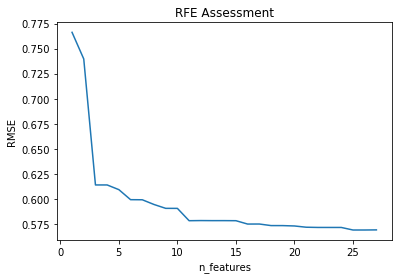

In [9]:
plt.plot(n_features_dict.keys(),n_features_dict.values())
plt.xlabel('n_features')
plt.ylabel('RMSE')
plt.title('RFE Assessment')
plt.show()

If we look at the figure above, we can see at x=11 RMSE falls sharply. This would be a number of features and is comporable to the number of features I reduced to in my Ridge exploration. Below I restrict the the dataset to the top 11 selected by RFE features and test for RMSE.

In [10]:
preprocess(lr_bb)

# fit data to a linear regression model
lm = LinearRegression()
Selector = RFE(lm, n_features_to_select=11, step=1, verbose=0)
reduced_lm = Selector.fit(X_train,y_train)

RFE_features = np.array(list(lr_bb.columns)[1:])
RFE_features = RFE_features[np.array(reduced_lm.support_)]
print(RFE_features)

RFE_bb = lr_bb[RFE_features]

['BSC' 'Rural_Pct' 'PctBachelors' 'InformationJobs' 'BornInState'
 'HighSchoolGrads' 'MobileHomes' 'NoEnglish' 'InformationJobsPer'
 'ArmedForcesPer' 'Unemployed']


In [11]:
Pipeline(RFE_bb, LinearRegression())

Training test CV scores:[ 0.46729722  0.4374322   0.42919033  0.45973047  0.45703664]
Hold-out RMSE: 0.5995774503721648
Linear model:
 0.035 * Rural_Pct
 + 0.03 * PctBachelors
 + 0.03 * NoEnglish
 + 0.027 * BornInState
 + -0.024 * MobileHomes
 + -0.021 * ArmedForcesPer
 + 0.01 * InformationJobsPer
 + -0.008 * HighSchoolGrads
 + -0.006 * InformationJobs
 + -0.005 * BSC
--------------------


Not bad! Like ridge regression, we can hold a steady RMSE with a significantly reduced number of features using this method.

What is interesting in comparing these two methods of feature engineering is which features were selected in each case. Ridge regression operates in a regularized manner, so that the features initially observed to be highly correlated with the target variable do not always end up having significant coefficients since the model is assessed and built in a totally different way. In contrast, RFE selects features that are less surprising given my findings in examing correlations between features and the target. 

### Random Forest Regression
Random Forest models are one of the popular and effective applications of machine learning for prediction. They are ensemble methods, building a multitude (a "forest") of if/then decision trees on randomized subsets of the data. This ensemble approach is superior to a single decision tree, which has a strong tendency to overfit. However, when many decision trees are created and averaged out, it creates a very powerful model with less of an overfitting tendency. They can be used for classification, or for regression as they are used here. One definite advantage of a Random Forest Regressor (RFR) in this case, though more often seen as a limitation, is that it will only predict values that it has encountered previously. Since we are predicting for a fixed 0-5 range and all those values are encountered in the data, this actually eliminates the need to place a ceiling on predictions as I did for the linear models.

In this case, I will user a parameter grid and GridSearchCV() to select the best hyperparameters for the RandomForest.

In [12]:
rf_bb = broadband.drop(['Unnamed: 0', 'state', 'statename'], axis=1)

X_train, X_holdout, y_train, y_holdout = preprocess(rf_bb)

param_grid = {'n_estimators': [20,40,60,80,100],
             'max_features': ['auto', 'log2', 'sqrt']}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5)

# evaluate RMSE on holdout set
grid_search.fit(X_train, y_train)
print("Holdout set score: {:.2f}".format(grid_search.score(X_holdout, y_holdout)))
print("Best parameters: {}".format(grid_search.best_params_))


Holdout set score: 0.70
Best parameters: {'max_features': 'sqrt', 'n_estimators': 100}


The grid search reveals two things. Increasing the size of my Random Forest will always yield better results, but the rate of return for more estimators decreases rapidly, while the time to run computations increases. By isolating scores from the best performing "max_features" method producing the plot below, I can identify an "elbow" point at n_features = 40. While this is not the best parameter overall, it works well when computation time is taken into account. In fact, when RMSE is calculated it performs better than any of the linear models! 

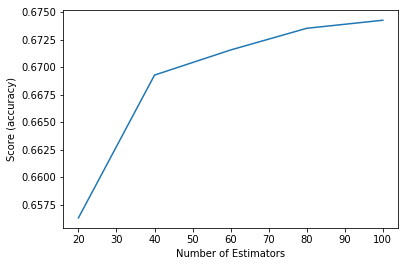

In [13]:
results = grid_search.cv_results_
sqrt_only = results['mean_test_score'][-5:]
plt.plot(param_grid['n_estimators'], sqrt_only)
plt.xlabel('Number of Estimators')
plt.ylabel('Score (accuracy)')
plt.show()

In [14]:
best_rf = grid_search.best_estimator_
BSC_predicted = best_rf.predict(X_holdout)
holdout_rmse = np.sqrt(mean_squared_error(BSC_predicted, y_holdout))
print(holdout_rmse)

0.445276201655


The Random Forest Regressor is returning some great results! This is very good. Is it possible to simplify the model further? Here, I create a report of the feature importances and then use that to create a new DataFrame that only uses features that are in top half of feature importances overall.

(plot_feature_importances function was copied from pg. 79 of *Introduction to Machine Learning with Python* by Müller & Guido)

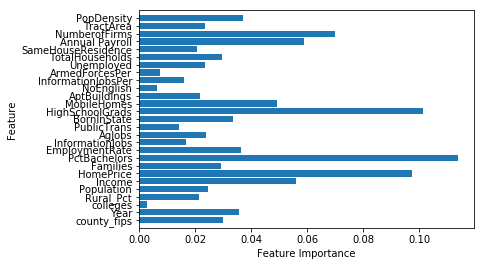

In [15]:
# the preprocess function used elsewhere cannot be used here 
rf_features_wNaN = rf_bb.drop('BSC',axis = 1)
rf_features = pd.DataFrame(imp.fit_transform(rf_features_wNaN))
rf_features.columns = rf_features_wNaN.columns

def plot_feature_importances(model):
    n_features = rf_features.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), list(rf_features.columns))
    plt.xlabel('Feature Importance')
    plt.ylabel("Feature")
    plt.ylim(-1,n_features)

plot_feature_importances(best_rf)
plt.show()

Looking at the results above, the important features are similar to the set identified in RFE and in the EDA previous to this module. This is further confirmed by producing a list of the features in the top half of feature importance below.

In [16]:
# Create a dict and use list comprehension to get the top half of scored features
rf_FI_dict = dict(zip(list(rf_features.columns),best_rf.feature_importances_))
FI_median = np.median(list(rf_FI_dict.values()))
high_FI_values  = [i for i in list(rf_FI_dict.values()) if i > FI_median]
high_FI_features = []
for k, v in rf_FI_dict.items(): 
    if v in high_FI_values: high_FI_features.append(k)
        
print(high_FI_features)

['county_fips', 'Year', 'Income', 'HomePrice', 'PctBachelors', 'EmploymentRate', 'BornInState', 'HighSchoolGrads', 'MobileHomes', 'TotalHouseholds', 'Annual Payroll', 'NumberofFirms', 'PopDensity']


Finally, to wrap up optimizing the Random Forest Model, I can use the results of the above to reduce the dataframe to the features identified as important and test for RMSE on that.

In [17]:
# add target variable and set data to important features
high_FI_features += ['BSC']
RF_optimized_bb = rf_bb[high_FI_features]

# split into training and test sets
X_train, X_holdout, y_train, y_holdout = preprocess(RF_optimized_bb)

# create the RFR object with the previously identified optimal parameters.
rf_optimized = RandomForestRegressor(n_estimators=40, max_features='sqrt')

# evaluate RMSE on holdout set
rf_optimized.fit(X_train, y_train)
BSC_predicted = rf_optimized.predict(X_holdout)
holdout_rmse = np.sqrt(mean_squared_error(BSC_predicted, y_holdout))
print("Number of features in dataset: ", len(high_FI_features)-1)
print("RMSE:", holdout_rmse)

Number of features in dataset:  13
RMSE: 0.452950735537


Awesome! The reduced dataframe produces an RMSE just slightly higher than the one using the full dataset. This means that the model was able to build out decision trees that predicted nearly as well even with a significantly reduced amount of information.

If the previous tests hadn't made it clear, RandomForestRegressors definitely seem to be the best performing model for this data, even with a reduced number of features. The RMSE score of .452 is significantly below anything produced by the Linear or Ridge regression model.

## Further Optimization

One useful improvement was segmenting the data based on its real-world origins. Each record is a county in a particular year, and we are trying to predict based on various demographic factors collected by the census bureau. In order to improve RMSE here, I segmented the data into three distinct DataFrames representing rural, semirural, and urban counties and trained a RFR model with previously identified optimal hyper-parameters on each (based on definitions from the Census Bureau). I did this because the various features operate differently at different levels of rurality, for example I discovered that income matters much less as rurality increases. The result is better trained models that produce lower RMSE scores overall.

In [18]:
# segment the DataFrames and train individual linear regression models on each
urban_bb = lr_bb[lr_bb['Rural_Pct'] < 50]
semirural_bb = lr_bb[(lr_bb['Rural_Pct'] > 50) & (broadband['Rural_Pct'] < 99.9)]
rural_bb = lr_bb[lr_bb['Rural_Pct'] == 100]

for subset in [urban_bb, semirural_bb, rural_bb]:
    print('n:', subset.shape[0])
    Pipeline(subset,RandomForestRegressor(n_estimators=40, max_features='sqrt'), coef_print=False)

n: 6285
Training test CV scores:[ 0.7043138   0.67182366  0.66890859  0.65040182  0.65235485]
Hold-out RMSE: 0.3761405355265361
--------------------
n: 5900
Training test CV scores:[ 0.61946137  0.59094376  0.58969741  0.61643137  0.5992256 ]
Hold-out RMSE: 0.45560132084896554
--------------------
n: 3493
Training test CV scores:[ 0.52546285  0.53926013  0.51697676  0.56953099  0.53923685]
Hold-out RMSE: 0.5370358893919408
--------------------


There is a lot to unpack here. Overall, I can predict urban and semirural counties fairly well and better than when the model is trained on the entire dataset. Urban counties in particular have an RMSE of .45, meaning that the average prediction is only off by .45. Considering that urban counties are the most numerous, this is good news. However, the more rural the county is, generally the worse off the model gets at predicting BSC.

## Applications

At this point it is good to ask two questions: What exaclty has been built in this and how is it useful? Reflecting again on the real-world origins and goals of this project, it is very useful to examine the residuals of the prediction since they show which counties would be best for further expansion by telecom companies. A histogram of the residuals (actual - predicted) is below.

Training test CV scores:[ 0.68355336  0.66127747  0.65837601  0.67427986  0.66553085]
Hold-out RMSE: 0.4482548599949421
--------------------


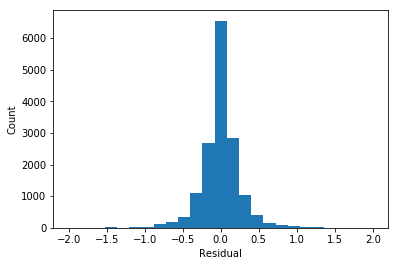

In [19]:
resid_df = Pipeline(lr_bb, RandomForestRegressor(n_estimators=40, max_features='sqrt'), coef_print=False, return_df=True)
plt.hist(resid_df.Residual, bins=25)
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

In [20]:
resid_df[resid_df['Year']==2011].to_csv('resid_map_2011.csv')
resid_df[resid_df['Year']==2015].to_csv('resid_map_2015.csv')

Since this project is based on geographical units, it makes sense to map our residuals (from RFR predictions) to see if there are any patterns. Below is a map of the residuals for 2015, with the coloration corresponding to the number of standard deviations from the mean of the residuals for that particular year. Put simply, red counties are overpredicted, and blue counties are underpredicted.

This map achieve the objective of this project: they identify areas that are underserved in home broadband subscription based on rigorous statistical calculation of factors that lead to broadband subscription rates. It should be noted that they are results from the generalized linear regression model rather than the segmented models from the "Further Optimization" section, but they still provide us, and telecom companies that are the theoretical consumers of this project, useful information. For example, it looks like in the most recent map that Arkansas, Mississippi and Lousiana in the south are the most underserved and could benefit from market expansion. Same with some areas of Nevada as well.

![2015 Residuals](2015_r_map.png)
<center> **2015 Residuals** </center>

## Conclusions

This project has successfully provided a predictive model for BSC, achieving an RMSE of .57 in the generalized model and as low as .45 for subsets of the data. Data was collected from a variety of sources, cleaned, and arranged. EDA was undertaken to determine general patterns in the data, as well as discovery of highly correlated features. In this final unit, a predictive linear regression model was built, simplified in two different ways, and used to produce a valuable map of residuals.

Further research could be undertaken to understand the high variance and poor predictability of in rural counties. Development of a feature that performs particularly well in rural counties would be very valuable in reducing overall RMSE. Additionally, spatial interpolation techniques could be used to improve accuracy of the predictions even further. I may return to this project in the future to do that, but will leave it for now.